# DCGAN Enhancement Experiments
## Architecture Modifications & Hyperparameter Tuning

### Component 1: Layer Modifications (10 marks)
- Deeper networks (more layers)
- Wider networks (more feature maps)
- Residual connections
- Self-attention mechanism
- Different activation functions

### Component 2: Hyperparameter Tuning (10 marks)
- Learning rates: [0.0001, 0.0002, 0.0005, 0.001]
- Batch sizes: [32, 64, 128]
- Latent dimensions: [32, 64, 100, 128]
- Beta parameters optimization
- Optimizer comparison

### Metrics:
- Generator & Discriminator Losses
- Training Time
- Image Quality Visual Assessment

In [1]:
# Import Libraries
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import kagglehub
import time
import json
from collections import defaultdict

# Set random seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


c:\Github\DL-Project\GEN-DL (true)\Gen-AI-DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")
print("Dataset path:", path)

labels = np.load(os.path.join(path, "sprites_labels.npy"))
data = np.load(os.path.join(path, "sprites.npy"))

# Prepare tensors
images_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Normalize to [-1, 1]
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0
images_tensor = images_tensor * 2.0 - 1.0

print(f"Data shape: {images_tensor.shape}")
print(f"Range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Dataset path: C:\Users\lukma\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Data shape: torch.Size([89400, 3, 16, 16])
Range: [-1.00, 1.00]


In [3]:
# Helper Functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def create_loader(images, labels, batch_size, workers=2):
    dataset = TensorDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                     num_workers=workers, drop_last=True)

def plot_comparison(results_dict, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for name, res in results_dict.items():
        plt.plot(res['G_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Generator Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for name, res in results_dict.items():
        plt.plot(res['D_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Discriminator Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("✓ Helper functions loaded")

✓ Helper functions loaded


## COMPONENT 1: Architecture Modifications

In [4]:
# Baseline Architecture
class BaselineGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_dim, 
                out_channels=ngf*8, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*8, 
                out_channels=ngf*4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*4,
                out_channels=nc,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class BaselineDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Baseline architecture")

✓ Baseline architecture


In [5]:
# Architecture 1: Deeper Network
class DeeperGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*16, 2, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class DeeperDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*4, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Deeper architecture")

✓ Deeper architecture


In [6]:
# Architecture 2: Wider Network
class WiderGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=64, nc=3):  # ngf doubled
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class WiderDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):  # ndf doubled
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Wider architecture")

✓ Wider architecture


In [7]:
# Architecture 3: Residual Connections
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class ResidualGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )
        self.res_blocks = nn.Sequential(ResBlock(ngf*8), ResBlock(ngf*8))
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.upsample(x)

print("✓ Residual architecture")

✓ Residual architecture


In [8]:
# Training Function with Image Display
def train_gan(netG, netD, loader, config, num_epochs, name="Experiment"):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, config['z_dim'], 1, 1, device=device)
    
    optimizerD = optim.Adam(netD.parameters(), lr=config['lrD'], 
                           betas=(config['beta1'], config['beta2']))
    optimizerG = optim.Adam(netG.parameters(), lr=config['lrG'], 
                           betas=(config['beta1'], config['beta2']))
    
    G_losses, D_losses, img_list = [], [], []
    start_time = time.time()
    
    print(f"\n{'='*60}\nTraining: {name}\n{'='*60}")
    
    for epoch in range(num_epochs):
        for i, data in enumerate(loader):
            # Update Discriminator
            netD.zero_grad()
            real = data[0].to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            
            output = netD(real).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            
            noise = torch.randn(b_size, config['z_dim'], 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.0)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
            
            # Update Generator
            netG.zero_grad()
            label.fill_(1.0)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}] G: {np.mean(G_losses[-len(loader):]):.4f} D: {np.mean(D_losses[-len(loader):]):.4f}")
    
    # Generate final images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=8)
    img_list.append(img_grid)
    
    # Display generated image for this experiment
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.title(f"Fake Images - {name}", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()
    
    return {
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list,
        'time': time.time() - start_time,
        'name': name
    }

print("✓ Training function ready")

✓ Training function ready


Dataset ready: 1396 batches

REAL IMAGES FROM DATASET


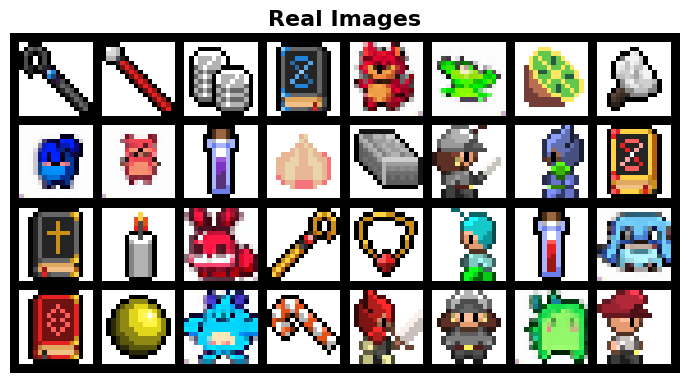

In [9]:
# Configuration
config = {
    'batch_size': 64,
    'z_dim': 64,
    'lrG': 0.0002,
    'lrD': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'num_epochs': 5
}

arch_results = {}
loader = create_loader(images_tensor, labels_tensor, config['batch_size'])
print(f"Dataset ready: {len(loader)} batches")

# Display Real Images FIRST
print("\n" + "="*70)
print("REAL IMAGES FROM DATASET")
print("="*70)
real_batch = next(iter(loader))
real_images = real_batch[0][:32]  # Take first 32 images

plt.figure(figsize=(7, 7))
plt.axis("off")
plt.title("Real Images", fontsize=16, fontweight='bold')
grid = vutils.make_grid(real_images, nrow=8, padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()


🔬 EXPERIMENT 1: Baseline

Training: Baseline
Epoch [1/5] G: 0.9068 D: 1.2217
Epoch [2/5] G: 1.5728 D: 0.6930
Epoch [3/5] G: 2.1224 D: 0.4482
Epoch [4/5] G: 2.5728 D: 0.3349
Epoch [5/5] G: 2.9346 D: 0.2784


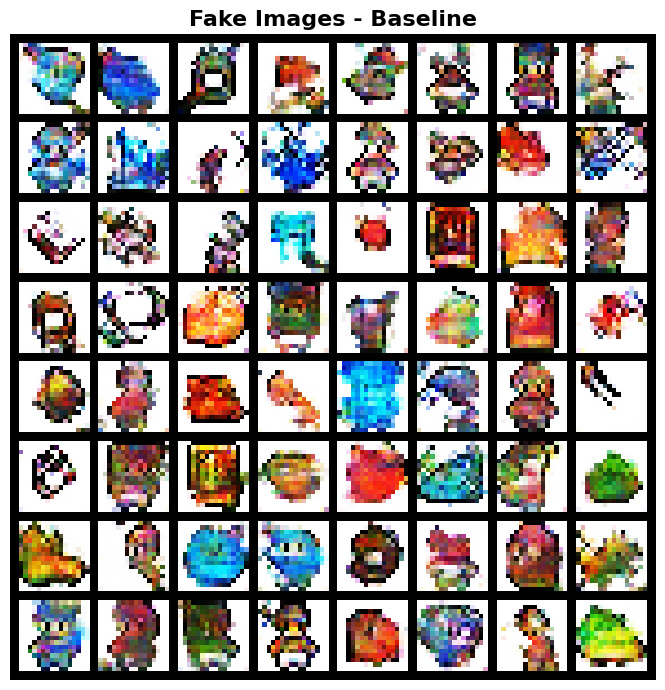

In [10]:
# Experiment 1: Baseline
print("\n🔬 EXPERIMENT 1: Baseline")
netG = BaselineGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Baseline'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Baseline")


🔬 EXPERIMENT 2: Deeper Network

Training: Deeper
Epoch [1/5] G: 1.1729 D: 1.1474
Epoch [2/5] G: 2.1746 D: 0.5105
Epoch [3/5] G: 3.2406 D: 0.2097
Epoch [4/5] G: 4.0287 D: 0.1145
Epoch [5/5] G: 4.4194 D: 0.1060


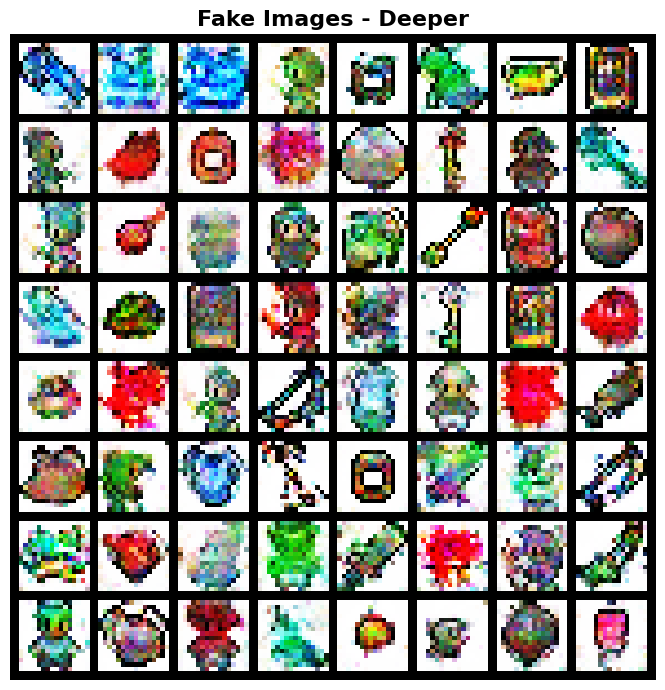

In [11]:
# Experiment 2: Deeper
print("\n🔬 EXPERIMENT 2: Deeper Network")
netG = DeeperGenerator(config['z_dim'], 32, 3).to(device)
netD = DeeperDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Deeper'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Deeper")


🔬 EXPERIMENT 3: Wider Network

Training: Wider
Epoch [1/5] G: 1.3208 D: 0.9920
Epoch [2/5] G: 2.2155 D: 0.4471
Epoch [3/5] G: 2.9955 D: 0.2577
Epoch [4/5] G: 3.5428 D: 0.1939
Epoch [5/5] G: 3.9696 D: 0.1535


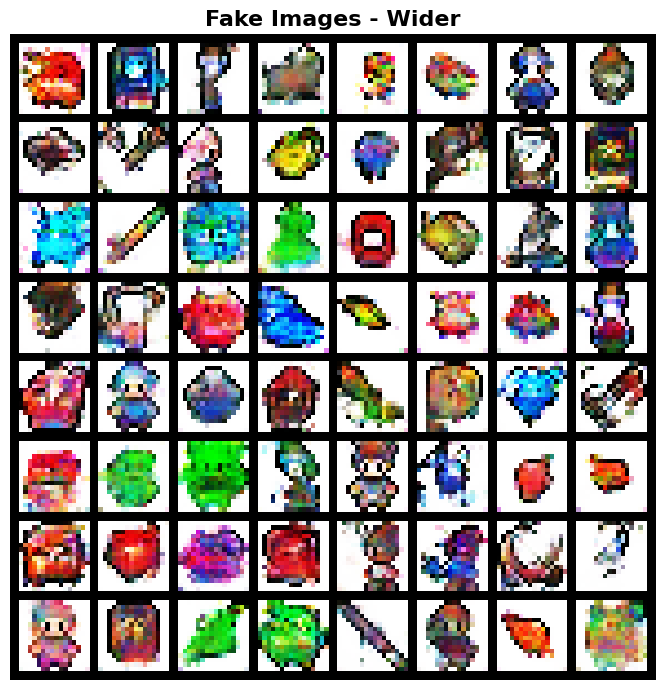

In [12]:
# Experiment 3: Wider
print("\n🔬 EXPERIMENT 3: Wider Network")
netG = WiderGenerator(config['z_dim'], 64, 3).to(device)
netD = WiderDiscriminator(3, 64).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Wider'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Wider")


🔬 EXPERIMENT 4: Residual Connections

Training: Residual
Epoch [1/5] G: 0.7691 D: 1.4997
Epoch [2/5] G: 0.7233 D: 1.4065
Epoch [3/5] G: 0.8158 D: 1.3445
Epoch [4/5] G: 0.9997 D: 1.2366
Epoch [5/5] G: 1.1876 D: 1.1160


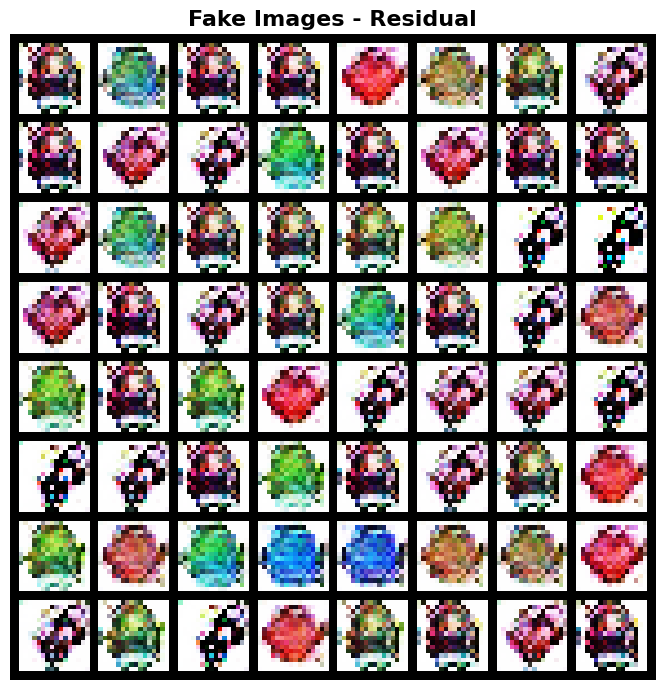

In [13]:
# Experiment 4: Residual
print("\n🔬 EXPERIMENT 4: Residual Connections")
netG = ResidualGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Residual'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Residual")


COMPONENT 1: ARCHITECTURE RESULTS SUMMARY


,Architecture,Avg G Loss,Avg D Loss,Final G Loss,Time (min)
0,Baseline,2.0219,0.5953,2.8005,1.51
1,Deeper,3.0073,0.4176,4.4443,1.77
2,Wider,2.8089,0.4088,4.3363,1.47
3,Residual,0.8991,1.3207,1.1106,1.88



GENERATED IMAGES COMPARISON


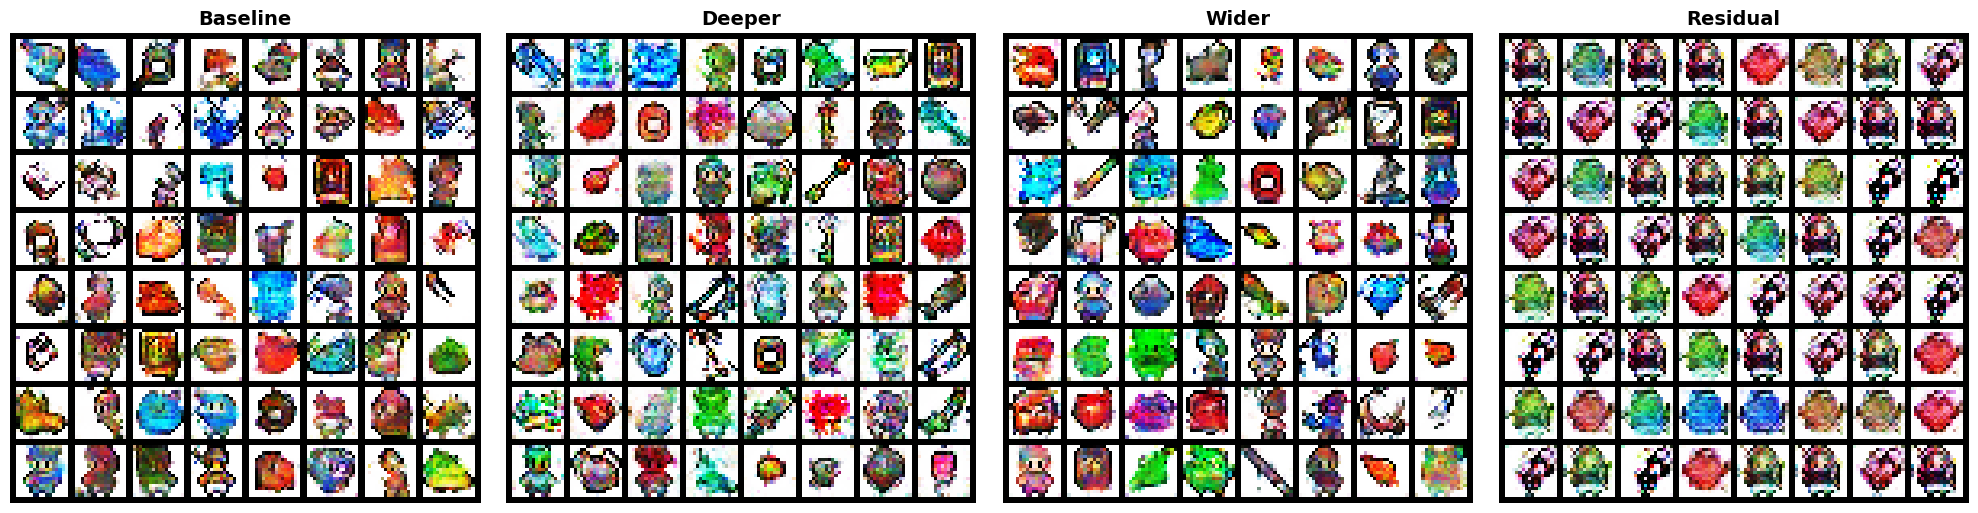

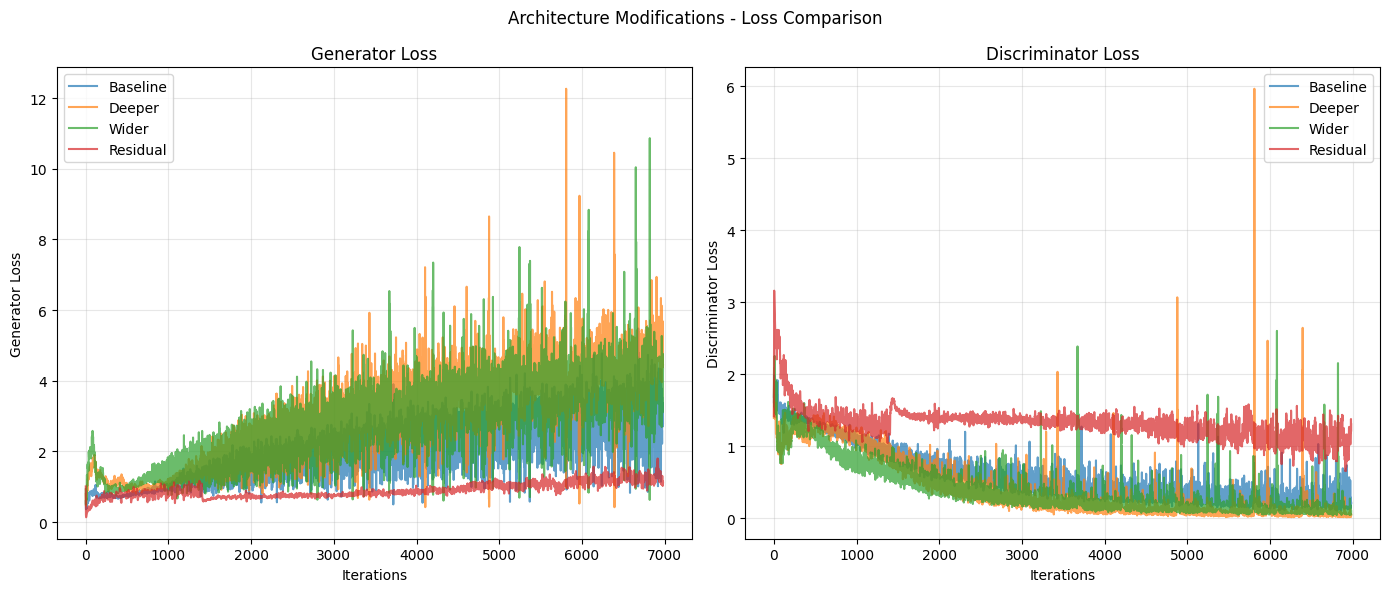

In [14]:
# Architecture Results
print("\n" + "="*70)
print("COMPONENT 1: ARCHITECTURE RESULTS SUMMARY")
print("="*70)

df_arch = pd.DataFrame([{
    'Architecture': name,
    'Avg G Loss': f"{np.mean(res['G_losses']):.4f}",
    'Avg D Loss': f"{np.mean(res['D_losses']):.4f}",
    'Final G Loss': f"{res['G_losses'][-1]:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in arch_results.items()])

display(df_arch)

# Show all generated images side by side
print("\n" + "="*70)
print("GENERATED IMAGES COMPARISON")
print("="*70)

n_arch = len(arch_results)
fig, axes = plt.subplots(1, n_arch, figsize=(5*n_arch, 5))

if n_arch == 1:
    axes = [axes]

for idx, (name, res) in enumerate(arch_results.items()):
    img = res['img_list'][-1]
    axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[idx].set_title(name, fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot losses
plot_comparison(arch_results, "Architecture Modifications - Loss Comparison")